In [47]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install nltk
#!pip install wordcloud
#!pip install sklearn
#pip install text_preprocessing


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [48]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
# Se toma una fucnion creada en SRC
from textpreprocessing import clean_stopwords 


In [36]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('/workspace/NLP/data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [38]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('/workspace/NLP/data/raw/trump_tweets (1).csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [39]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
8100,Twitter Web Client,309304210636300288,@homeedmam I wish him the best of luck.,2013-03-06T14:07:25Z,0,NaN,0,False
13350,Twitter for Android,635058369431252992,"Alabama was great last night, amazing people. ...",2015-08-22T11:58:08Z,3273,NaN,7551,False
3145,Twitter Web Client,220170240875700224,Great poll numbers for @MittRomney just out--h...,2012-07-03T15:00:50Z,137,NaN,25,False
3486,Twitter Web Client,199322476180815873,#CelebrityApprentice Boardrooms—can anything b...,2012-05-07T02:19:16Z,38,NaN,6,False
20391,Twitter for iPhone,838861512999649286,'President Trump Congratulates Exxon Mobil for...,2017-03-06T21:19:04Z,12846,NaN,70675,False
11024,Twitter for Android,484921289715376128,Do these very stupid politicians who got us in...,2014-07-04T04:46:59Z,87,NaN,105,False
19065,Twitter for iPhone,919313707355787264,The Democrats in the Southwest part of Virgini...,2017-10-14T21:27:22Z,16003,NaN,71175,False
13462,Twitter for Android,627841345789558788,I wish good luck to all of the Republican cand...,2015-08-02T14:00:16Z,6526,NaN,9636,False
4414,Twitter for Android,406400091092971520,I am in Miami at Trump National Doral. Just ga...,2013-11-29T12:31:46Z,42,NaN,68,False
10805,Twitter Web Client,496640871727906816,Doctors have already died treating Ebola http:...,2014-08-05T12:56:25Z,411,NaN,389,False


In [53]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [54]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [56]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [57]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [58]:
# 2.5 Consider time is UTC, convert to EST, le quita 5 horas a la hora UTC
df_interim['created_at'] +=pd.Timedelta(-5,unit='h')

In [60]:
# 2.5 Filter source for analysis, vamos a usar solamente los origenes que viene iphon o android
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [62]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [63]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [64]:
# 3.2 Get a sample, aca como no sa hacen predicciones lo vamos a revisar todo.
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
18054,Twitter for Android,"Jeb Bush spent more than $40,000,000 in New Ha...",2016-02-11 10:11:56,4418,12093
12735,Twitter for Android,.@Morning_Joe: Marco only won the debate in th...,2015-11-02 07:24:05,824,1755
12857,Twitter for Android,.@MonicaCrowley you were GREAT on @seanhannity...,2015-10-20 21:49:08,716,1848
12100,Twitter for Android,"My campaign for president is $35,000,000 under...",2015-12-29 09:33:51,3614,9464
16814,Twitter for Android,People very unhappy with Crooked Hillary and O...,2016-06-17 06:20:36,7217,22792
15819,Twitter for Android,"Wow, just saw the really bad @CNN ratings. Peo...",2016-10-01 16:25:52,10920,31493
16219,Twitter for iPhone,Great job today by the NYPD in protecting the ...,2016-08-10 21:07:07,8239,33325
18321,Twitter for iPhone,Judge Jeanine Slams GOP Establishment:\nhttps:...,2016-01-19 20:49:58,1859,4139
16593,Twitter for iPhone,"If I win the Presidency, we will swamp Justice...",2016-07-13 17:28:44,8126,26131
13843,Twitter for Android,Will be in Chicago tomorrow for a record setti...,2015-06-28 15:21:51,163,469


In [65]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [66]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

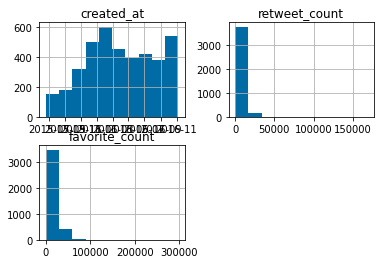

In [67]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show()

In [69]:
# 3.6 Make a plot of tweets frequence rate by source (assign columna nueva)
df_plot = (df
           .assign(hour=df['created_at'].dt.hour)
           .groupby(['source','hour'])
           .agg(count=('source','count'))
           .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())
           .reset_index())
df_plot


,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


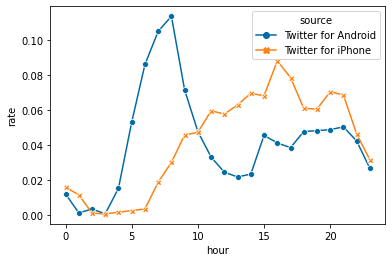

In [71]:
sns.lineplot(data=df_plot,x='hour',y='rate',hue='source',markers=True,style='source',dashes=False)
plt.show()

In [73]:
# 3.7 Get a glimpse of the most retweeted tweets

df.sort_values(by='retweet_count',ascending=False)[['text','retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [74]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count',ascending=False)[['text','favorite_count']][:10]

,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [76]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [77]:
# 3.10 Process text to extract stopwords con lambda me permite darle argumentos a la funcion si fuera uno no lo uso 
df['text_clean']=df.text.str.lower()
stop_dict=stopwords.words('english')
df['text_clean']=df['text_clean'].apply(lambda x:clean_stopwords(x,stop_dict=stop_dict))
df['text_clean']=df['text_clean'].str.replace(r'''['!,.]''','',regex=True)



In [78]:
# 3.11 Extract urls se saca porque linkea a una imagen
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean']=df['text_clean'].str.replace(url_pat,'',regex=True)


In [84]:
# 3.12 Extract special characters

df['text_clean']=df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''','',regex=True)

In [85]:
# 3.13 Extract numbers [\d] coleccion de digitos + si encuentra 1 0 +
df['text_clean']=df['text_clean'].str.replace(r'[\d]+','',regex=True)

In [86]:
# 3.14 See the results
df[['text','text_clean']].sample(10)

,text,text_clean
15512,Want access to Crooked Hillary? Don't forget -...,want access crooked hillary? forget going cos...
18158,I am in Iowa. Will be interviewed on This Week...,iowa interviewed week @gstephanopoulos morning...
15419,"I agree, @MMFlint- To all Americans, I see you...",agree @mmflint americans see hear you voice v...
12441,"I consider my health, stamina and strength one...",consider health stamina strength one greatest ...
12090,"Iowa was fantastic last night, amazing crowd a...",iowa fantastic last night amazing crowd people...
18168,The Cruz campaign issued a dishonest and decep...,cruz campaign issued dishonest deceptive get v...
15937,Once again someone we were told is ok turns ou...,someone told ok turns terrorist wants destroy ...
15984,CHILD CARE REFORMS THAT WILL MAKE AMERICA GREA...,child care reforms make america great again tr...
12653,.@KarlRove is a biased dope who wrote falsely ...,@karlrove biased dope wrote falsely china tpp ...
17719,I will be interviewed on @FaceTheNation this m...,interviewed @facethenation morning enjoy @jdic...


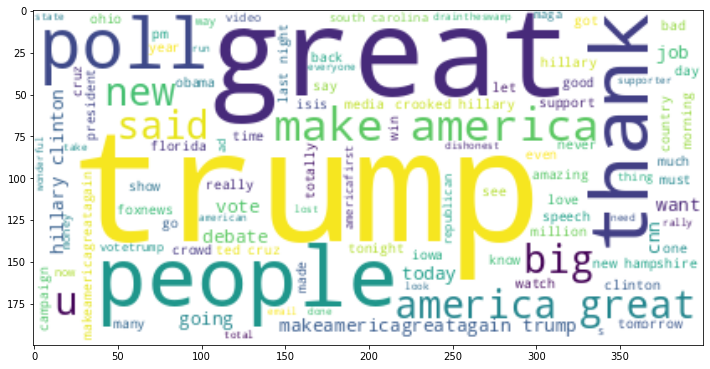

In [89]:
# 3.15 Let's see a wordcloud
text=''.join(i for i in df.text_clean)
wordcloud=WordCloud(max_words=100,background_color='white').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()


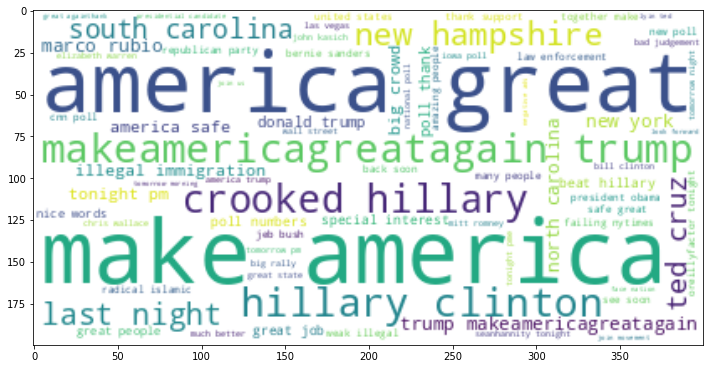

In [92]:
#Dos palabras que se repiten una y otra vez Bigramo dos palabras que van juntas

WordCloud_bg=WordCloud(collocation_threshold=True,max_words=100,background_color='white').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(WordCloud_bg,interpolation='bilinear')
plt.show()

In [97]:
#Trocear palabras con un sentimiento asociado y contar que sentimiento hay atras y que positivo y negativo 
df_word_split = (df
.drop(['text','created_at','retweet_count','favorite_count'],axis=1)
.assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split


,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [100]:
#aplicamos un join
df_word_split.merge(nrc[['word','sentiment']],on='word',how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [104]:
df_sent = df_word_split.\
merge(nrc[['word','sentiment']], on='word', how='inner').\
groupby(['source', 'sentiment']).agg(count=('sentiment', 'count')).\
reset_index().pivot_table(index=['sentiment'],columns=['source'], values='count').\
reset_index().\
rename(columns={'Twitter for Android': 'Android', 'Twitter for iPhone': 'iPhone'})

df_sent


source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [105]:
#frecuencia relativas
#odd ratio
#Vamos a calcular un intervalo de confianza

df_odd_ratio = df_sent.\
               assign(odd_ratio=(df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))
df_odd_ratio['log_or']=np.log(df_odd_ratio['odd_ratio'])


In [107]:
df_odd_ratio.sort_values(by=['log_or'],ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


#La log negativo muestran disgustos y son los del Android
#Iphone son mas positivos
#Con esto esoy probando que detras de esos dos celulares hay dos personas distintas
#Detras del iphone esta el equipo de campana 


Como se que esto no se dio al azar debeo contruir un intervalo de confianza si da 0 no, si no contiene O el tema es malo si contiene 0 es ambiguo.

In [108]:
# creamos intervalos de confianza
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android'] + 1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone']+1/(df_odd_ratio['iPhone'].sum()-df_odd_ratio['iPhone']))
df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_hight'] = df_odd_ratio['log_or'] + norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio.sort_values(by = 'log_or', ascending = False)

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_hight
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606


Intervalo de confianza no contiene 0 entonces si es buena aproximaccion si contenia el 0 puede salir por azar. Surpise contiene 0 no puede decir si es de Android o es iphone, no puedo decir mucho de sorprise pero si de los otros. El senior de iphone muy negativo y las personas que manejan Andoid muy positivos.

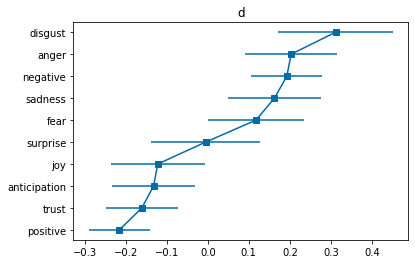

In [115]:
df_odd_ratio=df_odd_ratio.sort_values(by='log_or',ascending=True)
plt.errorbar(df_odd_ratio['log_or'],df_odd_ratio['sentiment'],marker='s',xerr=((df_odd_ratio.log_or-df_odd_ratio.conf_low),(df_odd_ratio.conf_hight-df_odd_ratio.log_or)))
plt.title('d')
plt.show()